# Import necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from transformers import BertTokenizer, TFBertModel
import joblib
import time
import re

# Load and Explore Dataset


In [ ]:
df = pd.read_csv("dataset_phishing.csv")
df.head()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate


In [ ]:
print(f"Dataset dimensions: {df.shape}")

Dataset dimensions: (11430, 89)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 89 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   url                         11430 non-null  object 
 1   length_url                  11430 non-null  int64  
 2   length_hostname             11430 non-null  int64  
 3   ip                          11430 non-null  int64  
 4   nb_dots                     11430 non-null  int64  
 5   nb_hyphens                  11430 non-null  int64  
 6   nb_at                       11430 non-null  int64  
 7   nb_qm                       11430 non-null  int64  
 8   nb_and                      11430 non-null  int64  
 9   nb_or                       11430 non-null  int64  
 10  nb_eq                       11430 non-null  int64  
 11  nb_underscore               11430 non-null  int64  
 12  nb_tilde                    11430 non-null  int64  
 13  nb_percent                  114

In [ ]:
df.describe()

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,...,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank
count,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.0,11430.000000,...,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,1.143000e+04,11430.000000,11430.000000,11430.000000
mean,61.126684,21.090289,0.150569,2.480752,0.997550,0.022222,0.141207,0.162292,0.0,0.293176,...,0.124759,0.775853,0.439545,0.072878,492.532196,4062.543745,8.567566e+05,0.020122,0.533946,3.185739
std,55.297318,10.777171,0.357644,1.369686,2.087087,0.155500,0.364456,0.821337,0.0,0.998317,...,0.330460,0.417038,0.496353,0.259948,814.769415,3107.784600,1.995606e+06,0.140425,0.498868,2.536955
min,12.000000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,-1.000000,-12.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,33.000000,15.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,1.000000,0.000000,0.000000,84.000000,972.250000,0.000000e+00,0.000000,0.000000,1.000000
50%,47.000000,19.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,1.000000,0.000000,0.000000,242.000000,3993.000000,1.651000e+03,0.000000,1.000000,3.000000
75%,71.000000,24.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,1.000000,1.000000,0.000000,449.000000,7026.750000,3.738455e+05,0.000000,1.000000,5.000000
max,1641.000000,214.000000,1.000000,24.000000,43.000000,4.000000,3.000000,19.000000,0.0,19.000000,...,1.000000,1.000000,1.000000,1.000000,29829.000000,12874.000000,1.076799e+07,1.000000,1.000000,10.000000


# Exploratory Data Analysis

In [ ]:
missing_values = df.isnull().sum()
print(f"Total missing values: {missing_values.sum()}")
missing_values[missing_values > 0]

Total missing values: 0


,0


In [ ]:
import tldextract

def create_engineered_features(df):
    df_new = df.copy()

    # TLD (top level domain)-based features
    suspicious_tlds = ['.xyz', '.tk', '.top', '.ml', '.ga', '.cf', '.gq', '.cc', '.pw']
    df_new['suspicious_tld'] = df_new['url'].apply(lambda x: 1 if any(x.lower().endswith(tld) for tld in suspicious_tlds) else 0)

    # Brand mismatch detection
    popular_brands = ['paypal', 'apple', 'google', 'microsoft', 'amazon',
                     'ebay', 'netflix', 'facebook', 'bank', 'chase',
                     'dropbox', 'linkedin', 'outlook', 'youtube', 'github']

    def detect_brand_mismatch(url):
        try:
            extracted = tldextract.extract(url.lower())
            domain_parts = extracted.domain.split('.')
            main_domain = domain_parts[-1] if len(domain_parts) > 1 else extracted.domain

            for brand in popular_brands:
                if brand in url.lower():
                    # Brand is in URL but not in main domain
                    if brand not in main_domain:
                        return 1
            return 0
        except:
            return 0

    df_new['brand_mismatch'] = df_new['url'].apply(detect_brand_mismatch)

    # Redirections
    redir_threshold = max(2, np.percentile(df_new['nb_redirection'], 80))
    df_new['many_redirections'] = df_new['nb_redirection'].apply(lambda x: 1 if x > redir_threshold else 0)

    # Misleading security indicators
    df_new['misleading_https'] = df_new.apply(lambda row: 1 if 'https' in row['url'].lower() and row['https_token'] == 0 else 0, axis=1)

    # Word-pattern features
    secure_keywords = ['secure', 'banking', 'login', 'update', 'account', 'verify', 'confirm', 'paypal', 'password']
    df_new['secure_keywords'] = df_new['url'].apply(lambda x: 1 if any(kw in x.lower() for kw in secure_keywords) else 0)

    # Special characters
    df_new['has_at_symbol'] = df_new['url'].apply(lambda x: 1 if "@" in x else 0)
    df_new['has_dash'] = df_new['url'].apply(lambda x: 1 if "-" in x else 0)

    # Subdomain depth
    df_new['subdomain_depth'] = df_new['url'].apply(lambda x: len(re.findall(r'\.', x.split('/')[2])) if len(x.split('/')) > 2 else 0)

    # Age-related features
    df_new['very_new_domain'] = df_new['domain_age'].apply(lambda x: 1 if x < 180 else 0)

    # IP address pattern
    df_new['ip_in_url'] = df_new['url'].apply(lambda x: 1 if re.search(r'(^|\D)(\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})($|\D)', x) else 0)

    # Dots frequency (normalized by URL length)
    df_new['dots_density'] = df_new['nb_dots'] / df_new['length_url'].apply(lambda x: max(x, 1))
    dots_density_threshold = np.percentile(df_new['dots_density'], 80)
    df_new['high_dots_density'] = df_new['dots_density'].apply(lambda x: 1 if x > dots_density_threshold else 0)

    # -- SMART LONG URL DETECTION --

    # Update suspicion score to include brand_mismatch
    df_new['suspicion_score'] = (
        df_new['has_at_symbol'] +
        df_new['has_dash'] +
        df_new['secure_keywords'] +
        df_new['high_dots_density'] +
        df_new['subdomain_depth'].apply(lambda x: 1 if x > 3 else 0) +
        df_new['many_redirections'] +
        df_new['misleading_https'] +
        df_new['ip_in_url'] +
        df_new['suspicious_tld'] +
        df_new['brand_mismatch']  # Added this
    )

    # Length-based flag only if suspicious
    url_length_threshold = np.percentile(df_new['length_url'], 80)
    df_new['long_url'] = df_new.apply(
        lambda row: 1 if row['length_url'] > url_length_threshold and row['suspicion_score'] >= 2 else 0,
        axis=1
    )

    return df_new

In [ ]:
df = create_engineered_features(df)

In [ ]:
df.head()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,has_at_symbol,has_dash,subdomain_depth,very_new_domain,ip_in_url,dots_density,high_dots_density,suspicion_score,long_url,brand_mismatch
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,0,2,1,0,0.081081,1,1,0,0
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,0,0,1,0,0,0.012987,0,0,0,0
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,0,1,4,0,0,0.031746,0,5,1,1
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,0,0,2,1,0,0.111111,1,1,0,0
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,2,0,0,0.036364,0,1,0,0


In [ ]:
feature_columns = [col for col in df.columns if col not in ['status', 'url']]
X_features = df[feature_columns].values
urls = df['url'].tolist()
y = (df['status'] == 'phishing').astype(int)

In [ ]:
X_train_features, X_test_features, urls_train, urls_test, y_train, y_test = train_test_split(X_features, urls, y, test_size=0.2, random_state=42)

print(f"Training set size: {len(urls_train)}")
print(f"Test set size: {len(urls_test)}")
print(f"Feature dimension: {X_train_features.shape[1]}")

Training set size: 9144
Test set size: 2286
Feature dimension: 101


In [ ]:
scaler = StandardScaler()
X_train_features_scaled = scaler.fit_transform(X_train_features)
X_test_features_scaled = scaler.transform(X_test_features)

In [ ]:
# Save the scaler for later use
joblib.dump(scaler, 'url_feature_scaler.joblib')
joblib.dump(feature_columns, 'feature_columns.joblib')

['feature_columns.joblib']

In [ ]:
# Load BERT tokenizer and model
print("Loading BERT model...")
start_time = time.time()
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
print(f"BERT model loaded in {time.time() - start_time:.2f} seconds")

Loading BERT model...


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

BERT model loaded in 2.69 seconds


In [ ]:
# Configure max length for URL tokenization
max_length = 64  # Most URLs will be shorter than this

def tokenize_urls(urls, tokenizer, max_length):
    """Tokenize a list of URLs for BERT processing"""
    return tokenizer(
        urls,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='tf'
    )

# Tokenize training and testing URLs
print("Tokenizing URLs...")
start_time = time.time()
train_encodings = tokenize_urls(urls_train, bert_tokenizer, max_length)
test_encodings = tokenize_urls(urls_test, bert_tokenizer, max_length)
print(f"Tokenization completed in {time.time() - start_time:.2f} seconds")

Tokenizing URLs...
Tokenization completed in 4.49 seconds


In [ ]:
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Concatenate, Lambda
from tensorflow.keras.models import Model
import tensorflow as tf

def create_hybrid_model(bert_model, feature_dim, max_length):
    """Create a hybrid model that uses both BERT and engineered features"""

    # BERT input layers
    input_ids = Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
    attention_mask = Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')

    # Wrap BERT call in a Lambda to fix KerasTensor issue
    def bert_embed(inputs):
        return bert_model(
            input_ids=inputs[0],
            attention_mask=inputs[1]
        )[1]  # Pooled output (CLS token)

    bert_output = Lambda(bert_embed, output_shape=(768,))([input_ids, attention_mask])
    bert_output = Dropout(0.1)(bert_output)

    # Engineered features input
    feature_input = Input(shape=(feature_dim,), dtype=tf.float32, name='engineered_features')

    feature_layer = Dense(64, activation='relu')(feature_input)
    feature_layer = BatchNormalization()(feature_layer)
    feature_layer = Dropout(0.2)(feature_layer)

    # Combine BERT and tabular
    combined = Concatenate()([bert_output, feature_layer])

    x = Dense(128, activation='relu')(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    output = Dense(1, activation='sigmoid')(x)

    model = Model(
        inputs=[input_ids, attention_mask, feature_input],
        outputs=output
    )

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
# Create the hybrid model
print("Creating hybrid model...")
feature_dim = X_train_features_scaled.shape[1]
hybrid_model = create_hybrid_model(bert_model, feature_dim, max_length)

print("Model summary:")
hybrid_model.summary()

Creating hybrid model...
Model summary:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ engineered_features │ (None, 101)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_ids           │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │      6,528 │ engineered_featu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 768)       │          0 │ input_ids[0][0],  │
│                     │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_12[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 768)       │          0 │ lambda_3[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 64)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 832)       │          0 │ dropout_12[0][0], │
│ (Concatenate)       │                   │            │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 128)       │    106,624 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_13[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 64)        │      8,256 │ dropout_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_14[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 64)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 1)         │         65 │ dropout_15[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 122,497 (478.50 KB)

 Trainable params: 121,985 (476.50 KB)

 Non-trainable params: 512 (2.00 KB)

In [ ]:
# Callbacks for training
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=0.0001,
        verbose=1
    )
]

In [ ]:
# Train the model
print("Training model...")
start_time = time.time()

history = hybrid_model.fit(
    {
        'input_ids': train_encodings['input_ids'],
        'attention_mask': train_encodings['attention_mask'],
        'engineered_features': X_train_features_scaled
    },
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=(
        {
            'input_ids': test_encodings['input_ids'],
            'attention_mask': test_encodings['attention_mask'],
            'engineered_features': X_test_features_scaled
        },
        y_test
    ),
    callbacks=callbacks,
    verbose=1
)

print(f"Training completed in {time.time() - start_time:.2f} seconds")

Training model...
Epoch 1/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 69s 170ms/step - accuracy: 0.8163 - loss: 0.4025 - val_accuracy: 0.9584 - val_loss: 0.1216 - learning_rate: 0.0010
Epoch 2/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 67s 138ms/step - accuracy: 0.9244 - loss: 0.2024 - val_accuracy: 0.9602 - val_loss: 0.1182 - learning_rate: 0.0010
Epoch 3/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 42s 141ms/step - accuracy: 0.9387 - loss: 0.1696 - val_accuracy: 0.9619 - val_loss: 0.1185 - learning_rate: 0.0010
Epoch 4/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 37s 130ms/step - accuracy: 0.9425 - loss: 0.1547 - val_accuracy: 0.9523 - val_loss: 0.1439 - learning_rate: 0.0010
Epoch 5/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9429 - loss: 0.1489
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
286/286 ━━━━━━━━━━━━━━━━━━━━ 41s 131ms/step - accuracy: 0.9429 - loss: 0.1489 - val_accuracy: 0.9479 - val_loss: 0.1566 - learning_rate: 0.0010
Epoch 6/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 44s 141ms/ste

In [ ]:
print("Evaluating model...")
y_pred_proba = hybrid_model.predict(
    {
        'input_ids': test_encodings['input_ids'],
        'attention_mask': test_encodings['attention_mask'],
        'engineered_features': X_test_features_scaled
    }
)
y_pred = (y_pred_proba > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Evaluating model...
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 175ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1157
           1       0.98      0.96      0.97      1129

    accuracy                           0.97      2286
   macro avg       0.97      0.97      0.97      2286
weighted avg       0.97      0.97      0.97      2286



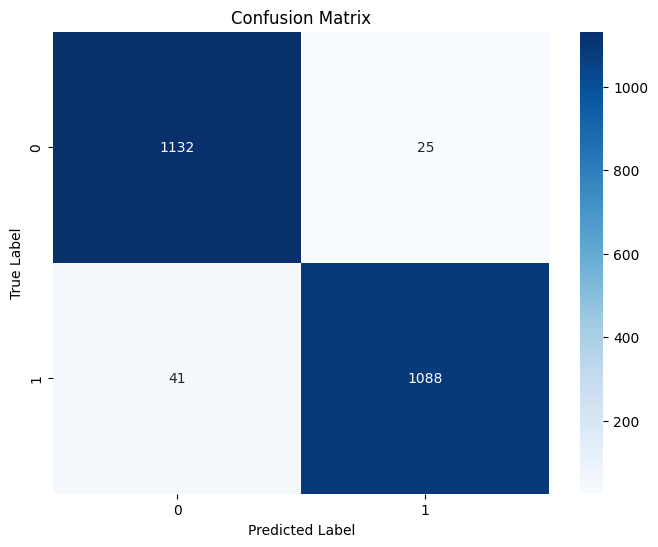

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png')
plt.show()

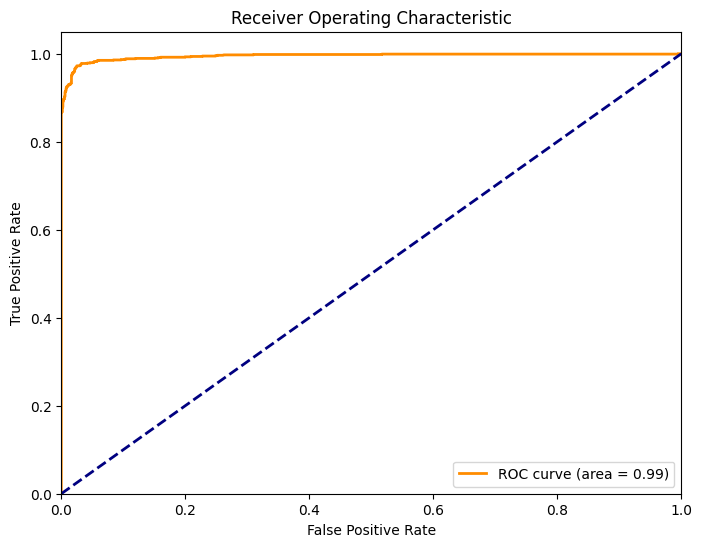

In [ ]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')
plt.show()

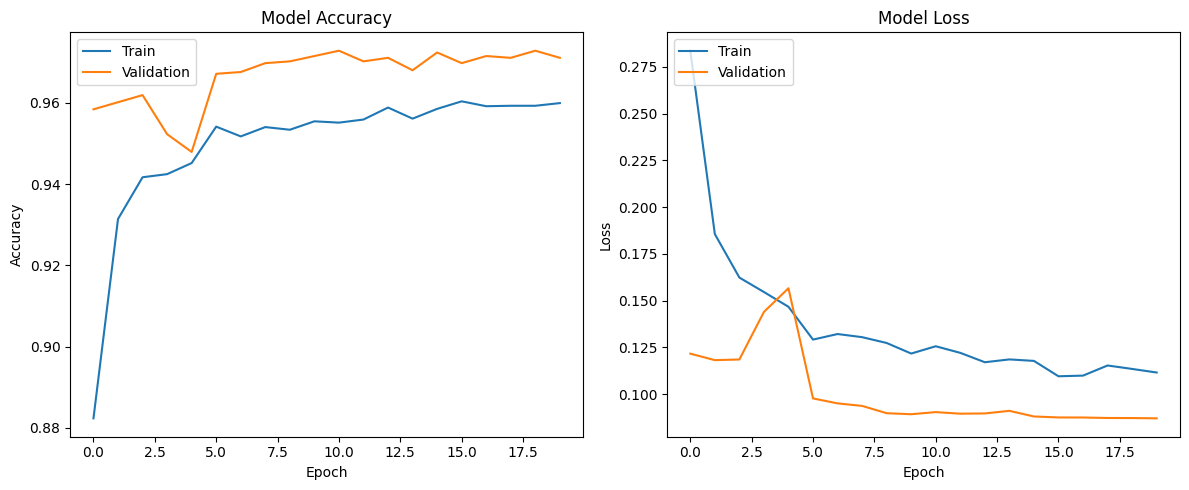

In [ ]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

In [ ]:
# Save the model
print("Saving model...")
hybrid_model.save('bert_engineered_features_model.keras')
print("Model saved.")

Saving model...
Model saved.


In [ ]:
def apply_post_prediction_rules(prediction, url):
    domain = tldextract.extract(url)

    # Rule 1: Suspicious TLD always phishing
    if prediction['features']['suspicious_tld'] == 1:
        prediction['prediction'] = 'phishing'
        prediction['probability'] = max(prediction['probability'], 0.95)

    # Rule 2: Brand mismatch always phishing
    elif prediction['features']['brand_mismatch'] == 1:
        prediction['prediction'] = 'phishing'
        prediction['probability'] = max(prediction['probability'], 0.9)

    # Rule 3: Known legitimate domains
    elif domain.domain in ['paypal', 'dropbox', 'google'] and domain.suffix in ['com', 'net', 'org']:
        prediction['prediction'] = 'legitimate'
        prediction['probability'] = min(prediction['probability'], 0.1)

    return prediction

In [ ]:
def predict_with_hybrid_model(
    url, model, tokenizer, scaler, feature_columns,
    create_engineered_features, df_template, max_length=64, threshold=0.5
):
    """
    Predict whether a URL is phishing using BERT and engineered features.
    """
    try:
        # Validate URL
        if not isinstance(url, str):
            raise ValueError("URL must be a string")
        url = url.strip()

        # Clone template and inject URL
        df_single = df_template.copy().iloc[0:1]
        df_single['url'] = url

        # Create engineered features
        df_single = create_engineered_features(df_single)

        # Check for required features
        missing_cols = [col for col in feature_columns if col not in df_single.columns]
        if missing_cols:
            raise ValueError(f"Missing feature columns: {missing_cols}")

        features = df_single[feature_columns].values
        features_scaled = scaler.transform(features)

        # Tokenize URL for BERT
        encodings = tokenizer(
            [url],
            padding='max_length',
            truncation=True,
            max_length=max_length,
            return_tensors='tf'
        )

        # Get prediction from model
        inputs = {
            'input_ids': encodings['input_ids'],
            'attention_mask': encodings['attention_mask'],
            'engineered_features': features_scaled
        }

        probability = float(model.predict(inputs)[0][0])
        prediction = "phishing" if probability > threshold else "legitimate"

        # Create prediction result with all required fields
        prediction_result = {
            "url": url,
            "prediction": prediction,
            "probability": probability,
            "confidence": f"{abs(0.5 - probability) * 2 * 100:.2f}%",
            "features": {
                'suspicious_tld': int(df_single['suspicious_tld'].iloc[0]),
                'brand_mismatch': int(df_single.get('brand_mismatch', 0).iloc[0]),
                'https_token': int(df_single['https_token'].iloc[0]),
                'nb_redirection': int(df_single['nb_redirection'].iloc[0])
            }
        }

        # Apply post-prediction rules if no error occurred
        if 'error' not in prediction_result:
            prediction_result = apply_post_prediction_rules(prediction_result, url)
            probability = prediction_result['probability']
            prediction_result['confidence'] = f"{abs(0.5 - probability) * 2 * 100:.2f}%"

        return prediction_result

    except Exception as e:
        error_msg = f"[ERROR] Failed to predict for URL '{url}': {str(e)}"
        print(error_msg)
        return {
            "url": url,
            "error": error_msg,
            "prediction": "error",
            "probability": 0.5,
            "confidence": "0%"
        }

In [ ]:
test_urls = [
  "https://www.google.com",
  "https://www.apple.com",
  "http://amaz0n-secure.com-findpackage.info",
  "http://bit.ly/2JhYLEy",
  "http://paypal.login-authentication.xyz",
  "http://update.facebook.com.login-verify.net",
  "http://login.amazon.customer-account-review.com",
  "http://microsoftsupport.alerts-update.net",
  "http://ebay-login.customersecuritycenter.com",
  "http://account.netflix.billing-verify.tk",
  "http://verify.outlook.mail-login-check.com",
  "https://www.youtube.com/watch?v=7q8Uw3rmXyE&t=165s",
  "https://claude.ai/chat/5c8ae569-787e-4c10-a7ba-6f6fd20ac274",
  "http://activate.facebook.fblogins.net/88adbao798283o8298398?login.asp",
  "https://github.com/Malvericus/ScamSentry/blob/main/Phase1/scam_detection.ipynb"
]

# test_urls = [
#     # Legitimate
#     "https://www.dropbox.com/login",
#     "https://accounts.google.com/ServiceLogin",
#     "https://www.netflix.com/browse",
#     "https://www.linkedin.com/in/john-doe",
#     "https://www.paypal.com/myaccount/home",
#     "https://support.apple.com/en-us/HT204034",
#     "https://signin.ebay.com/ws/eBayISAPI.dll?SignIn",
#     "https://www.amazon.co.uk/gp/help/customer/display.html",
#     "https://outlook.live.com/mail/",
#     "https://www.microsoft.com/en-us/security",

#     # Tricky / Spoofed Brand URLs
#     "http://paypal.login-authentication.xyz",
#     "http://secure.appleid.apple-login-verification.com",
#     "http://update.facebook.com.login-verify.net",
#     "http://google-support-verify.com",
#     "http://login.amazon.customer-account-review.com",
#     "http://microsoftsupport.alerts-update.net",
#     "http://ebay-login.customersecuritycenter.com",
#     "http://account.netflix.billing-verify.tk",
#     "http://icloud-security.appleid-reset.org",
#     "http://verify.outlook.mail-login-check.com",

#     # Clearly Phishing
#     "http://bit.ly/2HjdXQe",
#     "http://secure-login.verify-account.ml",
#     "http://paypal-user-authentication.cf",
#     "http://bankofamerica.alert.verifyaccount.cc",
#     "http://www.facebook.com.login.attempt-security.pw",
#     "http://www.youtube.com-security.ga",
#     "http://chaseonline.updateauth.gq",
#     "http://login-confirmation.tumblr.com-user-authentication.tk",
#     "http://github.com-login-update.verification-id.ga",
#     "http://icloud-lock-warning-update.pw"
# ]


df_template = df.iloc[0:1].copy()

for url in test_urls:
    result = predict_with_hybrid_model(
        url,
        hybrid_model,
        bert_tokenizer,
        scaler,
        feature_columns,
        create_engineered_features,
        df_template
    )
    print(f"URL: {url}")
    print(f"Prediction: {result['prediction']} (Probability: {result['probability']:.4f}, Confidence: {result['confidence']})")
    print("-" * 50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
URL: https://www.google.com
Prediction: legitimate (Probability: 0.0999, Confidence: 80.03%)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
URL: https://www.apple.com
Prediction: legitimate (Probability: 0.0610, Confidence: 87.81%)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
URL: http://amaz0n-secure.com-findpackage.info
Prediction: phishing (Probability: 0.5207, Confidence: 4.14%)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
URL: http://bit.ly/2JhYLEy
Prediction: legitimate (Probability: 0.4289, Confidence: 14.21%)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
URL: http://paypal.login-authentication.xyz
Prediction: phishing (Probability: 0.9997, Confidence: 99.94%)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
URL: http://update.faceb

In [34]:
# Install TensorFlow.js converter if not already installed
!pip install tensorflowjs

# Convert the Keras model to TensorFlow.js format
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(hybrid_model, 'tfjs_model')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


failed to lookup keras version from the file,
    this is likely a weight only file


In [35]:
# Zip the model directory to make it easier to download
!zip -r tfjs_model.zip tfjs_model/

  adding: tfjs_model/ (stored 0%)
  adding: tfjs_model/model.json (deflated 88%)
  adding: tfjs_model/group1-shard1of1.bin (deflated 8%)


## Split data

## Scale features


# Model building

# Model Training

# Model Evaluation

# Saving the Model

# URL Feature Extraction

Extract features from a URL

Predict whether a URL is legitimate or phishing

Function to check user-provided URLs


# Main Program